In [11]:
import pandas as pd
import random
import itertools
import numpy as np
import matplotlib.pyplot as plt
from fairlearn.datasets import fetch_acs_income
import shap
from scipy.spatial.distance import cosine, euclidean
from scipy.stats import ttest_ind, mannwhitneyu
from xgboost import XGBRegressor #continuous values?
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, TargetEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
import tensorflow
from tensorflow import keras
from keras import layers

### Simple FFN

In [12]:
data = fetch_acs_income()
# convert to df
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target
df = df.drop(columns=['ST', 'RELP'], errors='ignore')

# change 'MAR' values -> convert 2–5 to 0 (e.g., not married)
df['MAR'] = df['MAR'].apply(lambda x: 0 if x in [2, 3, 4, 5] else x)

# filter out individuals younger than 18
df = df[df['AGEP'] >= 18]

# keep rows where 'WKHP' is between 36 and 60 inclusive
df = df[(df['WKHP'] >= 30) & (df['WKHP'] <= 60)]

print(df.head())

   AGEP  COW  SCHL  MAR    OCCP  POBP  WKHP  SEX  RAC1P   target
1  53.0  5.0  17.0  0.0  3605.0  18.0  40.0  1.0    1.0  10000.0
2  41.0  1.0  16.0  0.0  7330.0   1.0  40.0  1.0    1.0  24000.0
4  21.0  5.0  19.0  0.0  3870.0  12.0  50.0  1.0    1.0  29000.0
5  37.0  5.0  16.0  0.0  9620.0   1.0  35.0  1.0    2.0  24100.0
7  51.0  1.0  20.0  0.0  5840.0   1.0  60.0  2.0    1.0  30000.0


In [13]:
# Log-transform target
y = np.log1p(df['target'])
X= df.drop(columns=['target'])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Feature types
categorical_features = ['MAR', 'SEX', 'OCCP', 'POBP', 'RAC1P', 'COW']
numeric_features = ['AGEP', 'WKHP']

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
    ('num', StandardScaler(), numeric_features)
])

# Fit on training data, transform both train and test
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [14]:
X.isna().sum()

AGEP     0
COW      0
SCHL     0
MAR      0
OCCP     0
POBP     0
WKHP     0
SEX      0
RAC1P    0
dtype: int64

In [18]:
def build_ffn(input_dim, n_hidden=2, n_neurons=64, dropout_rate=0.1, learning_rate=1e-3):
    model = keras.Sequential()
    model.add(keras.Input(shape=(input_dim,)))
    for _ in range(n_hidden):
        model.add(layers.Dense(n_neurons, activation='relu'))
        model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(1))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='mse',
                  metrics=['mae'])
    return model

# 3. Define search space
param_grid = {
    'n_hidden': [2, 3],
    'n_neurons': [32,64, 128],
    'dropout_rate': [0.1, 0.2, 0.3],
    'learning_rate': [1e-2, 1e-3],
    'batch_size': [18, 36],
    'epochs': [25, 40]
}

# Convert to list of param combinations
param_combinations = list(itertools.product(
    param_grid['n_hidden'],
    param_grid['n_neurons'],
    param_grid['dropout_rate'],
    param_grid['learning_rate'],
    param_grid['batch_size'],
    param_grid['epochs']
))

# Randomly sample N combinations
N = 10
random.seed(42)
sampled_params = random.sample(param_combinations, N)

# 4. Run search
best_score = float('inf')
best_model = None
best_params = None
best_history = None 


input_dim = X_train_processed.shape[1]

for i, (n_hidden, n_neurons, dropout_rate, learning_rate, batch_size, epochs) in enumerate(sampled_params):
    print(f"Training model {i+1}/{N} with params:")
    print(f"  hidden={n_hidden}, neurons={n_neurons}, dropout={dropout_rate}, lr={learning_rate}, batch={batch_size}, epochs={epochs}")
    
    model = build_ffn(input_dim, n_hidden, n_neurons, dropout_rate, learning_rate)
    
    history = model.fit(
        X_train_processed, y_train,
        validation_split=0.1,
        epochs=epochs,
        batch_size=batch_size,
        verbose=0
    )

    val_loss = history.history['val_loss'][-1]
    
    if val_loss < best_score:
        best_score = val_loss
        best_model = model
        best_history = history
        best_params = {
            'n_hidden': n_hidden,
            'n_neurons': n_neurons,
            'dropout_rate': dropout_rate,
            'learning_rate': learning_rate,
            'batch_size': batch_size,
            'epochs': epochs
        }

# 5. Evaluate best model on test set
y_pred = np.expm1(best_model.predict(X_test_processed).flatten())
y_true = np.expm1(y_test)

rmse = np.sqrt(root_mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("\nBest Params:", best_params)
print(f"FFN RMSE: {rmse:.2f}")
print(f"FFN MAE: {mae:.2f}")
print(f"FFN R²: {r2:.2f}")

Training model 1/10 with params:
  hidden=2, neurons=64, dropout=0.1, lr=0.001, batch=18, epochs=25
Training model 2/10 with params:
  hidden=2, neurons=32, dropout=0.1, lr=0.001, batch=36, epochs=25
Training model 3/10 with params:
  hidden=2, neurons=128, dropout=0.3, lr=0.001, batch=36, epochs=25
Training model 4/10 with params:
  hidden=2, neurons=128, dropout=0.2, lr=0.001, batch=36, epochs=25
Training model 5/10 with params:
  hidden=2, neurons=128, dropout=0.2, lr=0.01, batch=18, epochs=40
Training model 6/10 with params:
  hidden=2, neurons=64, dropout=0.2, lr=0.01, batch=36, epochs=40
Training model 7/10 with params:
  hidden=2, neurons=64, dropout=0.1, lr=0.01, batch=36, epochs=25
Training model 8/10 with params:
  hidden=3, neurons=128, dropout=0.3, lr=0.01, batch=36, epochs=40
Training model 9/10 with params:
  hidden=2, neurons=32, dropout=0.3, lr=0.001, batch=36, epochs=25
Training model 10/10 with params:
  hidden=3, neurons=64, dropout=0.2, lr=0.001, batch=18, epochs=25

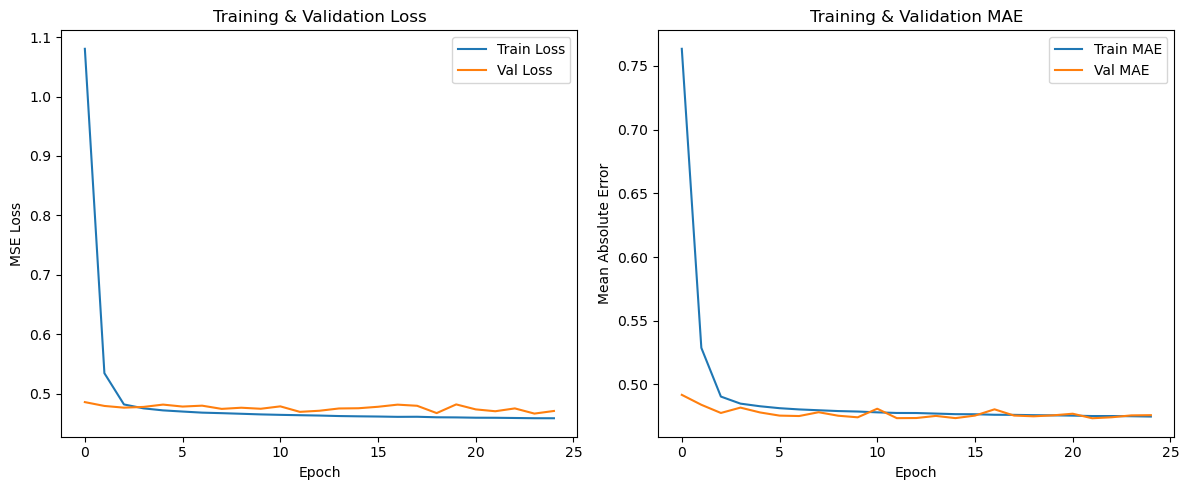

In [19]:
# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(best_history.history['loss'], label='Train Loss')
plt.plot(best_history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(best_history.history['mae'], label='Train MAE')
plt.plot(best_history.history['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.title('Training & Validation MAE')
plt.legend()

plt.tight_layout()
plt.show()


## XGBoost

In [2]:
data = fetch_acs_income()
# convert to df
df = pd.DataFrame(data.data, columns=data.feature_names)

# create target column
df['target'] = data.target
print(data.feature_names)
print(df.head())

['AGEP', 'COW', 'SCHL', 'MAR', 'OCCP', 'POBP', 'RELP', 'WKHP', 'SEX', 'RAC1P', 'ST']
   AGEP  COW  SCHL  MAR    OCCP  POBP  RELP  WKHP  SEX  RAC1P  ST   target
0  18.0  1.0  18.0  5.0  4720.0  13.0  17.0  21.0  2.0    2.0 NaN   1600.0
1  53.0  5.0  17.0  5.0  3605.0  18.0  16.0  40.0  1.0    1.0 NaN  10000.0
2  41.0  1.0  16.0  5.0  7330.0   1.0  17.0  40.0  1.0    1.0 NaN  24000.0
3  18.0  6.0  18.0  5.0  2722.0   1.0  17.0   2.0  2.0    1.0 NaN    180.0
4  21.0  5.0  19.0  5.0  3870.0  12.0  17.0  50.0  1.0    1.0 NaN  29000.0


In [14]:
# remove the 'ST' column
df = df.drop(columns=['ST', 'RELP'], errors='ignore')

# change 'MAR' values -> convert 2–5 to 0 (e.g., not married)
df['MAR'] = df['MAR'].apply(lambda x: 0 if x in [2, 3, 4, 5] else x)

# filter out individuals younger than 18
df = df[df['AGEP'] >= 18]

# keep rows where 'WKHP' is between 36 and 60 inclusive
df = df[(df['WKHP'] >= 30) & (df['WKHP'] <= 60)]

# reset index after filtering
df = df.reset_index(drop=True)

In [15]:
# mapping from numeric codes to race category names
race_labels = {
    1: "White alone",
    2: "Black or African American alone",
    3: "American Indian alone",
    4: "Alaska Native alone",
    5: "American Indian and Alaska Native tribes specified or not specified",
    6: "Asian alone",
    7: "Native Hawaiian and Other Pacific Islander alone",
    8: "Some Other Race alone",
    9: "Two or More races"
}

rac1p_counts = df['RAC1P'].value_counts().sort_index()
# calc length for alignment
max_label_len = max(len(label) for label in race_labels.values())

# match labels
print(f"{'Race Category'.ljust(max_label_len)} | Count")
print("-" * (max_label_len + 8))
for code, count in rac1p_counts.items():
    label = race_labels.get(code, f"Unknown ({code})")
    print(f"{label.ljust(max_label_len)} | {count}")

Race Category                                                       | Count
---------------------------------------------------------------------------
White alone                                                         | 1030553
Black or African American alone                                     | 117711
Asian alone                                                         | 77610
Two or More races                                                   | 31559


In [16]:
selected_codes = [1, 2, 6, 9]
subset_count = df['RAC1P'].isin(selected_codes).sum()
print(f"Total count for RAC1P categories {selected_codes}: {subset_count}")

Total count for RAC1P categories [1, 2, 6, 9]: 1257433


In [17]:
df = df[df['RAC1P'].isin(selected_codes)].reset_index(drop=True)

In [18]:
# mapping occupation codes to broader categories
def recode_occp(occp_code):
    if 10 <= occp_code <= 3550: # Management, Business, Science, and Arts Occupations
        return 1
    elif 3601 <= occp_code <= 4655: # "Service Occupations"
        return 2
    elif 4700 <= occp_code <= 5940: # "Sales and Office Occupations"
        return 3
    elif 6005 <= occp_code <= 7640: # "Natural Resources, Construction, and Maintenance Occupations"
        return 4
    elif 7700 <= occp_code <= 9760: # "Production, Transportation, and Material Moving Occupations"
        return 5
    elif 9800 <= occp_code <= 9830: # Military Specific Occupations
        return 6
    else:
        return 0 
    
df["OCCP_cat"] = df["OCCP"].apply(recode_occp)
df.drop(columns="OCCP")

,AGEP,SCHL,MAR,POBP,WKHP,SEX,RAC1P,target,OCCP_cat,SCHL_cat,Nativity
0,53.0,17.0,0.0,18.0,40.0,1.0,1.0,10000.0,2,2,1
1,41.0,16.0,0.0,1.0,40.0,1.0,1.0,24000.0,4,2,1
2,21.0,19.0,0.0,12.0,50.0,1.0,1.0,29000.0,2,2,1
3,37.0,16.0,0.0,1.0,35.0,1.0,2.0,24100.0,5,2,1
4,51.0,20.0,0.0,1.0,60.0,2.0,1.0,30000.0,3,3,1
...,...,...,...,...,...,...,...,...,...,...,...
1257428,65.0,21.0,0.0,72.0,40.0,2.0,9.0,90000.0,1,4,0
1257429,43.0,21.0,0.0,72.0,40.0,1.0,9.0,17300.0,2,4,0
1257430,45.0,16.0,0.0,72.0,40.0,2.0,1.0,30000.0,2,2,0
1257431,37.0,19.0,0.0,17.0,40.0,2.0,9.0,19700.0,5,2,1


In [19]:
def recode_schl(schl_code):
    if schl_code <= 15: # No high school diploma
        return 1
    elif 15 <= schl_code <= 19: # High school diploma or equivalent
        return 2
    elif schl_code == 20: # Associate's degree
        return 3
    elif schl_code == 21: # Bachelor's degree
        return 4
    elif 22 <= schl_code <= 23: # Master's or professional degree
        return 5
    elif schl_code == 24: # Doctorate's degree
        return 6 
    
df["SCHL_cat"] = df["SCHL"].apply(recode_schl)
df.drop(columns="SCHL")

,AGEP,MAR,OCCP,POBP,WKHP,SEX,RAC1P,target,OCCP_cat,SCHL_cat,Nativity
0,53.0,0.0,3605.0,18.0,40.0,1.0,1.0,10000.0,2,2,1
1,41.0,0.0,7330.0,1.0,40.0,1.0,1.0,24000.0,4,2,1
2,21.0,0.0,3870.0,12.0,50.0,1.0,1.0,29000.0,2,2,1
3,37.0,0.0,9620.0,1.0,35.0,1.0,2.0,24100.0,5,2,1
4,51.0,0.0,5840.0,1.0,60.0,2.0,1.0,30000.0,3,3,1
...,...,...,...,...,...,...,...,...,...,...,...
1257428,65.0,0.0,3050.0,72.0,40.0,2.0,9.0,90000.0,1,4,0
1257429,43.0,0.0,4040.0,72.0,40.0,1.0,9.0,17300.0,2,4,0
1257430,45.0,0.0,4510.0,72.0,40.0,2.0,1.0,30000.0,2,2,0
1257431,37.0,0.0,7750.0,17.0,40.0,2.0,9.0,19700.0,5,2,1


In [20]:
df['Nativity'] = df['POBP'].apply(lambda x: 1 if x <= 56 else 0) # 1[born on mainland US (50 states)]

In [21]:
# number of instances after filtering
print(len(df))
#check for any missing values/NaN
df.isnull().values.any()

1257433


np.False_

### Preprocessing for linreg

In [22]:
# Define features
#cat_features_linreg = ['COW', 'SCHL', 'OCCP', 'POBP', 'RELP', 'RAC1P', 'MAR', 'SEX']
cat_features_linreg =['RAC1P', 'MAR', 'SEX', 'OCCP_cat', 'SCHL_cat', 'Nativity']
num_features_linreg = ['AGEP', 'WKHP']
features_linreg = num_features_linreg + cat_features_linreg

# Define X and log-transformed y
X_linreg = df[features_linreg]
y_linreg = np.log1p(df['target'])  # log(1 + y) to handle zero targets if present

# Train-test split
X_train_linreg, X_test_linreg, y_train_linreg, y_test_linreg = train_test_split(
    X_linreg, y_linreg, test_size=0.2, random_state=42
)

# Preprocessing
preprocessor_linreg = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(drop='first'), cat_features_linreg)],
    remainder='passthrough'
)

# Transform features
X_train_encoded_linreg = preprocessor_linreg.fit_transform(X_train_linreg)
X_test_encoded_linreg = preprocessor_linreg.transform(X_test_linreg)


## Model training & evaluation

### Baseline model - Linear regression

In [23]:
# Train model on log-transformed target
model_linreg = LinearRegression()
model_linreg.fit(X_train_encoded_linreg, y_train_linreg)

# Predict on test set (log scale)
y_pred_log = model_linreg.predict(X_test_encoded_linreg)

# Inverse transform to original scale
y_pred = np.expm1(y_pred_log)  # exp(y) - 1
y_true = np.expm1(y_test_linreg)  # same inverse for y_test

# Evaluation
rmse = np.sqrt(root_mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Linear Regression (log-transformed target) RMSE: {rmse:.2f}")
print(f"Linear Regression (log-transformed target) MAE: {mae:.2f}")
print(f"Linear Regression (log-transformed target) R²: {r2:.2f}")

Linear Regression (log-transformed target) RMSE: 257.79
Linear Regression (log-transformed target) MAE: 31467.68
Linear Regression (log-transformed target) R²: 0.22


### XGBoost Regressor development

In [25]:
#cat_cols = ['COW', 'SCHL', 'OCCP', 'POBP', 'RELP', 'RAC1P', 'SEX', 'MAR']
num_cols = ['AGEP', 'WKHP']
cat_cols = ['RAC1P', 'MAR', 'SEX', 'OCCP_cat', 'SCHL_cat', 'Nativity']
X = df[cat_cols + num_cols]
y = np.log1p(df['target'])  # target log-transformed


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
results = X_test.copy()
# Preprocessor: apply TargetEncoder only to categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', TargetEncoder(), cat_cols)
    ],
    remainder='passthrough'
)


pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(objective='reg:squarederror', tree_method='hist', random_state=42))
])

# Parameter grid (note: prefix parameters with 'model__')
param_grid = {
    'model__n_estimators': [50, 100, 150, 200,250],
    'model__max_depth': [4, 6, 8, 10, 15],
    'model__learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2],
    'model__subsample': [0.6, 0.7, 0.8, 1.0],
    'model__colsample_bytree': [0.5, 0.7, 0.8, 1.0],
    'model__reg_alpha': [0, 0.1, 1, 10],
    'model__reg_lambda': [0, 1, 2, 5, 10, 20],
    'model__min_child_weight': [1, 5, 10],
    'model__gamma': [0, 0.1, 0.5, 1],
    'model__max_delta_step': [0, 1, 5],
}


# Grid search with cross-validation
grid_search = RandomizedSearchCV(pipe, param_distributions=param_grid, cv=3, n_iter=50,
                                  random_state=42)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
# Predict and evaluate on test set
y_pred = np.expm1(best_model.predict(X_test))
y_testy = np.expm1(y_test)

rmse = np.sqrt(root_mean_squared_error(y_testy, y_pred))
mae = mean_absolute_error(y_testy, y_pred)
r2 = r2_score(y_testy, y_pred)

print("Best Parameters:", grid_search.best_params_)
print(f"Tuned RMSE: {rmse:.2f}")
print(f"Tuned MAE: {mae:.2f}")
print(f"Tuned R²: {r2:.2f}")


Best Parameters: {'model__subsample': 0.6, 'model__reg_lambda': 5, 'model__reg_alpha': 10, 'model__n_estimators': 150, 'model__min_child_weight': 10, 'model__max_depth': 10, 'model__max_delta_step': 0, 'model__learning_rate': 0.05, 'model__gamma': 0, 'model__colsample_bytree': 0.8}
Tuned RMSE: 255.99
Tuned MAE: 30141.87
Tuned R²: 0.24


**Linear regression model (baseline)**

Linear Regression (log-transformed target) RMSE: 251.86

Linear Regression (log-transformed target) MAE: 29039.46

Linear Regression (log-transformed target) R²: 0.32

**Finetuned XGBoostRegressor**

with log transform

Tuned RMSE: 248.83

Tuned MAE: 28081.60

Tuned R²: 0.35

### Visualizing MSE

In [14]:
results['pred'] = y_pred
subgroup_mse = results.groupby('RAC1P', group_keys=False, observed =True).apply(lambda g: root_mean_squared_error(g['true'], g['pred']))

print("MSE per RAC1P group:")
print(subgroup_mse)

KeyError: 'true'

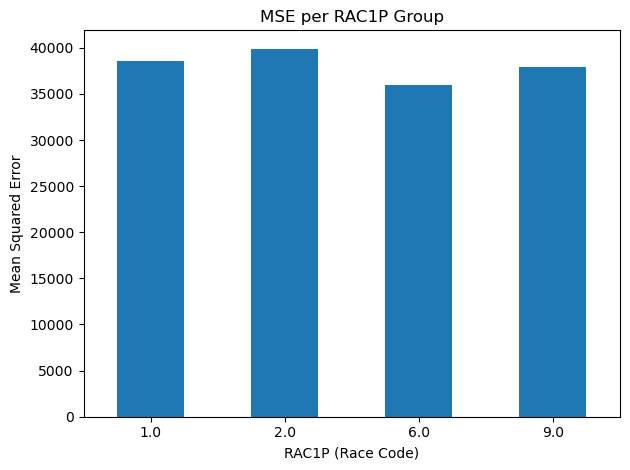

In [ ]:
subgroup_mse.plot(kind='bar', title='MSE per RAC1P Group')
plt.ylabel("Mean Squared Error")
plt.xlabel("RAC1P (Race Code)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## SHAP value analysis between subgroups

In [ ]:
# shap compatibility
X_train = X_train.astype(float)
X_test = X_test.astype(float)

In [ ]:
# use TreeSHAP
explainer = shap.TreeExplainer(best_model, X_train)

# SHAP values for test set
shap_values = explainer(X_test)

NameError: name 'best_model' is not defined

In [ ]:
#  base values and shap values
shap_matrix = np.array([sv.values for sv in shap_values])  # shape: [n_samples, n_features]

# put shap values with the original test set
shap_df = pd.DataFrame(shap_matrix, columns=X_test.columns)
shap_df['RAC1P'] = results['RAC1P']
shap_df['SEX'] = results['SEX']
shap_df['true'] = results['true']
shap_df['pred'] = results['pred']
shap_df['correct'] = np.isclose(shap_df['true'], shap_df['pred'], atol=10000)  # example tolerance

KeyboardInterrupt: 

In [ ]:

group = (shap_df['RAC1P'] == 1) 
correct = shap_matrix[group & shap_df['correct']]
incorrect = shap_matrix[group & (~shap_df['correct'])]

# aggregate mean vectors
mean_correct = np.mean(correct, axis=0)
mean_incorrect = np.mean(incorrect, axis=0)

#  distance metrics
cosine_dist = cosine(mean_correct, mean_incorrect)
l2_dist = euclidean(mean_correct, mean_incorrect)

to do: make efficient script to go through all distances

In [ ]:
mean_white = np.mean(shap_matrix[shap_df['RAC1P'] == 1], axis=0)
mean_black = np.mean(shap_matrix[shap_df['RAC1P'] == 2], axis=0)

cosine_dist_group = cosine(mean_white, mean_black)
l2_dist_group = euclidean(mean_white, mean_black)

In [ ]:
mean_white = np.mean(shap_matrix[shap_df['RAC1P'] == 1], axis=0)
mean_asian = np.mean(shap_matrix[shap_df['RAC1P'] == 6], axis=0)

cosine_dist_group = cosine(mean_white, mean_asian)
l2_dist_group = euclidean(mean_white, mean_asian)

In [ ]:
# change? because flattening shap vector means testing all feature contributions
shap_vals_white = shap_matrix[shap_df['RAC1P'] == 1].flatten()
shap_vals_black = shap_matrix[shap_df['RAC1P'] == 2].flatten()

# determine data distribution first
t_stat, t_p = ttest_ind(shap_vals_white, shap_vals_black, equal_var=False)
u_stat, u_p = mannwhitneyu(shap_vals_white, shap_vals_black)

print("T-test p:", t_p)
print("Mann-Whitney U p:", u_p)
